 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/Data-Science-Bowl-2018/Mask_RCNN/nuclei_train-vYohann.ipynb#Detection" data-toc-modified-id="Detection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Detection</a></span></li><li><span><a href="http://localhost:8888/notebooks/Data-Science-Bowl-2018/Mask_RCNN/nuclei_train-vYohann.ipynb#Prediction-and-sub" data-toc-modified-id="Prediction-and-sub-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prediction and sub</a></span></li></ul></div>

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import skimage
from config import Config
import utils
import model as modellib
import visualize
from model import log
import itertools



from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# # Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)
#    
seed=16

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Nuclei_new_dat"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 512

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 250

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 65
    
    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 300

    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               300
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           Nuclei_new_dat
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAI

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class nuclei_dataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    gob_path=None
    def load_im(self, list_id, glob_path ):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        self.glob_path=glob_path
        # Add classes
        self.add_class("stage1_train", 1, "nuclei")

        # Add images
        k=0
        for Id in list_id:
            self.add_image("stage1_train", image_id=k, 
                           path=os.path.join(self.glob_path,Id,"images",Id+".png"),
                          id_str=Id)
            k+=1

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:,:,:3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image

#     def image_reference(self, image_id):
#         """Return the shapes data of the image."""
#         info = self.image_info[image_id]
#         if info["source"] == "shapes":
#             return info["shapes"]
#         else:
#             super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # Override this function to load a mask from your dataset.
        # Otherwise, it returns an empty mask.
        path_masks=os.path.join(self.glob_path,self.image_info[image_id]["id_str"],"masks")
        mask=[]
        for id_mask in os.listdir(path_masks):
            mask+=[skimage.io.imread(os.path.join(path_masks,id_mask),as_grey=True)]
            
        mask=np.array(mask)
        mask=mask.transpose((1,2,0))
        class_ids = np.ones(mask.shape[2],np.int32)
        return mask, class_ids

In [5]:
# ici il y a des modifications à faire car 6 images en tout dans les images train
# je fais la modif de sorte qu'aux images enlevées près, les ensembles train et validation restent les mêmes

path_to_input="/home/ubuntu/Kaggle-Data-Science-Bowl/input"
labels=pd.read_csv(os.path.join(path_to_input, "stage1_train_labels.csv"))
ImageId=labels.ImageId.unique()

glob_path=os.path.join(path_to_input ,"stage1_train")
ImageId2 = os.listdir(glob_path)

ImageId_train,ImageId_val=train_test_split(ImageId, test_size=0.2, random_state=seed)
ImageId_train = np.intersect1d(ImageId_train, ImageId2)
ImageId_val = np.intersect1d(ImageId_val, ImageId2)

print("len ImageId_train:",len(ImageId_train))
print("len ImageId_val:",len(ImageId_val))
# Training dataset
dataset_train = nuclei_dataset()
dataset_train.load_im(ImageId_train,glob_path)
dataset_train.prepare()

# # Validation dataset
dataset_val = nuclei_dataset()
dataset_val.load_im(ImageId_val,glob_path)
dataset_val.prepare()

len ImageId_train: 531
len ImageId_val: 133


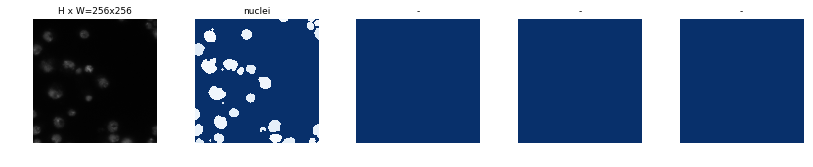

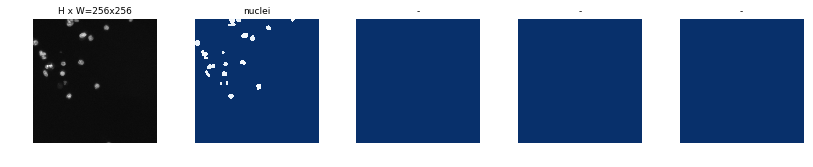

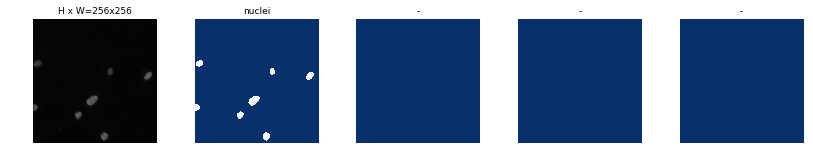

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [37]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=0.001,#config.LEARNING_RATE, #essaie d'un plus petit learning rate
            epochs=55, 
            layers='heads')



Starting at epoch 46. LR=0.001

Checkpoint Path: /home/ubuntu/Kaggle-Data-Science-Bowl/common/Mask_RCNN/logs/nuclei_new_dat20180312T0927/mask_rcnn_nuclei_new_dat_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
m

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 47/55
108/250 [===========>..................] - ETA: 7:30 - loss: 0.6132 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2009 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.1856

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


203/250 [=======================>......] - ETA: 2:24 - loss: 0.6227 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1984 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.1933

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


250/250 [==============================] - 765s 3s/step - loss: 0.6169 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.1967 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.1182 - mrcnn_mask_loss: 0.1937 - val_loss: 0.4713 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.1344 - val_mrcnn_class_loss: 0.0617 - val_mrcnn_bbox_loss: 0.0925 - val_mrcnn_mask_loss: 0.1798
Epoch 48/55
250/250 [==============================] - 743s 3s/step - loss: 0.6180 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.1912 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2009 - val_loss: 0.4360 - val_rpn_class_loss: 0.0024 - val_rpn_bbox_loss: 0.1295 - val_mrcnn_class_loss: 0.0694 - val_mrcnn_bbox_loss: 0.0730 - val_mrcnn_mask_loss: 0.1616
Epoch 49/55
250/250 [==============================] - 743s 3s/step - loss: 0.5950 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.1864 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.1951 - val_loss: 0.4894 - val_rpn_class_loss: 0.00

In [38]:
model.train(dataset_train, dataset_val, 
            learning_rate=0.0001,#config.LEARNING_RATE, #essaie d'un plus petit learning rate
            epochs=60, 
            layers='4+')


Starting at epoch 55. LR=0.0001

Checkpoint Path: /home/ubuntu/Kaggle-Data-Science-Bowl/common/Mask_RCNN/logs/nuclei_new_dat20180312T0927/mask_rcnn_nuclei_new_dat_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (Ba

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 56/60
 62/250 [======>.......................] - ETA: 12:19 - loss: 0.5996 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1764 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.1988

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 95/250 [==========>...................] - ETA: 9:53 - loss: 0.5740 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1686 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1039 - mrcnn_mask_loss: 0.1941

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


250/250 [==============================] - 926s 4s/step - loss: 0.5596 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1635 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.1007 - mrcnn_mask_loss: 0.1913 - val_loss: 0.8744 - val_rpn_class_loss: 0.0222 - val_rpn_bbox_loss: 0.3788 - val_mrcnn_class_loss: 0.1276 - val_mrcnn_bbox_loss: 0.1367 - val_mrcnn_mask_loss: 0.2092
Epoch 57/60
250/250 [==============================] - 898s 4s/step - loss: 0.5361 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1577 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1860 - val_loss: 0.8818 - val_rpn_class_loss: 0.0250 - val_rpn_bbox_loss: 0.4082 - val_mrcnn_class_loss: 0.1156 - val_mrcnn_bbox_loss: 0.1345 - val_mrcnn_mask_loss: 0.1984
Epoch 58/60
250/250 [==============================] - 904s 4s/step - loss: 0.5322 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1535 - mrcnn_class_loss: 0.0846 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1884 - val_loss: 0.9248 - val_rpn_class_loss: 0.02

# Detection

In [24]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 300
    DETECTION_NMS_THRESHOLD = 0.3#0.2

        
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.9
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [25]:
# Get path to saved weights
# Either set a specific path or find last trained weights
#model_path = os.path.join(ROOT_DIR, "logs/nuclei_new_dat20180312T0927/mask_rcnn_nuclei_new_dat_0054.h5")
model_path = os.path.join(ROOT_DIR, "logs/nuclei_new_dat20180312T0927/mask_rcnn_nuclei_new_dat_0060.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/Kaggle-Data-Science-Bowl/common/Mask_RCNN/logs/nuclei_new_dat20180312T0927/mask_rcnn_nuclei_new_dat_0060.h5


In [ ]:
# Test on a random image
image_id = dataset_val.image_ids[89]#np.random.choice(dataset_val.image_ids)

image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
shape = image.shape

# Bounding boxes. 
bbox = utils.extract_bboxes(mask)

log("image", image)
log("class_id", class_ids)
log("bbox", bbox)
log("mask", mask)

visualize.display_instances(image, bbox, mask, class_ids, 
                            dataset_train.class_names, figsize=(11, 11))

In [ ]:
results = model.detect([image], verbose=1)

r = results[0]
print(r["masks"].shape)

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, 
                            dataset_train.class_names, figsize=(8, 8))
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(8, 8))

In [ ]:
# visualize result on bad score images
#4,8,11,12,23,72,89

image_id = dataset_val.image_ids[12]#np.random.choice(dataset_val.image_ids)

image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
shape = image.shape

# Bounding boxes. 
bbox = utils.extract_bboxes(mask)

################
results = model.detect([image], verbose=1)

r = results[0]
print(r["masks"].shape)

################
imshow(image)
visualize.display_instances(image, bbox, mask, class_ids, 
                            dataset_train.class_names, figsize=(8, 8))
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(8, 8))


print(metric(mask,r["masks"],verbose=0))



In [ ]:
np.sqrt((mask != 0).sum(axis = (0, 1)))

In [ ]:
print((mask != 0).sum(axis = (0, 1)).mean())
print((r["masks"] != 0).sum(axis = (0, 1)).mean())

In [10]:
def clear_overlap(masks,threshold=0.55):
    res=np.zeros((masks.shape[0],masks.shape[1]),np.int32)
    for k in range(masks.shape[2]):
        l=k+1
        res+=l*masks[:,:,k]
        ind = (res>l)
        if ind.sum()/masks[:,:,k].sum() > threshold:
            res[ind]=l
        else:
            res[ind]+=-l
    return res

def metric(true_masks, pred_masks,verbose=0):
    
    (height , width , _)=pred_masks.shape
    # Make a ground truth prediction image (pixel value is index of object pred)
#     predictions = np.zeros((height, width), np.uint16)
#     for index in range(pred_masks.shape[2]): #donne un label different a chaque masque
#         predictions[pred_masks[:,:,index] > 0] = index + 1
    predictions=clear_overlap(pred_masks)
    # Make a ground truth label image (pixel value is index of object label)
    labels = np.zeros((height, width), np.uint16)
    for index in range(true_masks.shape[2]): #donne un label different a chaque masque
        labels[true_masks[:,:,index] > 0] = index + 1


    # Compute number of objects
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(predictions))
    if verbose > 0:
        print("Number of true objects:", true_objects-1)
        print("Number of predicted objects:", pred_objects-1)

    # Compute intersection between all objects
    intersection = np.histogram2d(labels.flatten(), predictions.flatten(), bins=(true_objects, pred_objects))[0]
    #matrice de taille (true_objects x pred_objects)
    #chaque case de la matrice correspond au nombre de pixels contenu dans chaque intersection

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]#vecteur qui associe a chaque objet le nombre de pixels qu'il contient
    area_pred = np.histogram(predictions, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]#on retire le fond
    union = union[1:,1:]
    union[union == 0] = 1e-9 #simple precaution

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects, une ligne correspond a un vrai masque, on compte le nombre de vrais masques qui ont une intersection plus grande que iou avec nos propositions
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects, une colonne corespond a un masque predit, on compte le nombre de fois ou l'intersection avec un vrai masque ne depasse pas iou
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects, on compte le nombre de fois ou l'intersection avec une prediction ne depasse pas iou
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn


    # Loop over IoU thresholds
    prec = []
    if verbose > 0 : 
        print("Thresh\tTP\tFP\tFN\tPrec.")#je l'ai garde du code original mais on peut le retirer
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp*1. / (tp + fp + fn) # il faut certainement changer tp*1. par tp pour qu'il tourne avec python 3
        
        if verbose > 0 : 
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    if verbose > 0 :
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

In [19]:
# résultats du modèle de référence (poids "mask_rcnn_nuclei_dat_0050.h5")
all_metric=[]
for image_id in dataset_val.image_ids:

    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    shape = image.shape
    results = model.detect([image], verbose=0)
    r = results[0]
    print( "image id: ", image_id)
    mtr=metric(mask,r["masks"],verbose=0)
    print( "metric: ", mtr)
    all_metric+=[mtr]

image id:  0
metric:  0.4597461209243847
image id:  1
metric:  0.14900145752252064
image id:  2
metric:  0.4133333333333333
image id:  3
metric:  0.8387106227106227
image id:  4
metric:  0.6799849675842793
image id:  5
metric:  0.4776002710773614
image id:  6
metric:  0.8539682539682539
image id:  7
metric:  0.3704689879350699
image id:  8
metric:  0.9111111111111111
image id:  9
metric:  0.7214652014652014
image id:  10
metric:  0.82188995215311
image id:  11
metric:  0.24432271460451327
image id:  12
metric:  0.8039673913043479
image id:  13
metric:  0.6944305694305696
image id:  14
metric:  0.24303584629888225
image id:  15
metric:  0.25234487734487737
image id:  16
metric:  0.41096990574465364
image id:  17
metric:  0.7599597953216375
image id:  18
metric:  0.6691351345443417
image id:  19
metric:  0.4602555224307919
image id:  20
metric:  0.46746962059870645
image id:  21
metric:  0.32642338296125356
image id:  22
metric:  0.3246007767944672
image id:  23
metric:  0.76980332402644

In [20]:
# score a battre
np.array(all_metric).mean()

0.5593900133263321

In [26]:
all_metric=[]
for image_id in dataset_val.image_ids:

    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    shape = image.shape
    results = model.detect([image], verbose=0)
    r = results[0]
    print( "image id: ", image_id)
    mtr=metric(mask,r["masks"],verbose=0)
    print( "metric: ", mtr)
    all_metric+=[mtr]

image id:  0
metric:  0.41942932869949584
image id:  1
metric:  0.16150353080764732
image id:  2
metric:  0.3411111111111111
image id:  3
metric:  0.8229632107023411
image id:  4
metric:  0.6960145754628513
image id:  5
metric:  0.4500224354216896
image id:  6
metric:  0.8539682539682539
image id:  7
metric:  0.36061561770158435
image id:  8
metric:  0.8666666666666666
image id:  9
metric:  0.7045238095238096
image id:  10
metric:  0.835755548799027
image id:  11
metric:  0.2770076706918812
image id:  12
metric:  0.7644296536796537
image id:  13
metric:  0.6857570207570207
image id:  14
metric:  0.1958671471425815
image id:  15
metric:  0.26186058792466116
image id:  16
metric:  0.34442923607168385
image id:  17
metric:  0.7701937134502924
image id:  18
metric:  0.6421645962732919
image id:  19
metric:  0.5257837396625801
image id:  20
metric:  0.4959905890260676
image id:  21
metric:  0.36359654409287956
image id:  22
metric:  0.32400456503671704
image id:  23
metric:  0.7434488561817

In [27]:
# nouveaua score
np.array(all_metric).mean()

0.5537180816937053

In [ ]:
# loop over the parameters DETECTION_MAX_INSTANCES and DETECTION_NMS_THRESHOLD

def expand_grid(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys()).astype('float32')

def optim_param(list_DETECTION_MIN_CONFIDENCE, list_DETECTION_NMS_THRESHOLD, model_path):
    
    param_dict = {'DETECTION_MIN_CONFIDENCE': list_DETECTION_MIN_CONFIDENCE,
                  'DETECTION_NMS_THRESHOLD' : list_DETECTION_NMS_THRESHOLD}
    param = expand_grid(param_dict)
    
    res=[]
    
    for i in range(param.shape[0]):
        class InferenceConfig(NucleiConfig):
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1

            # Max number of final detections
            DETECTION_MAX_INSTANCES = 300
            DETECTION_NMS_THRESHOLD = param['DETECTION_NMS_THRESHOLD'][i]


            # Minimum probability value to accept a detected instance
            # ROIs below this threshold are skipped
            DETECTION_MIN_CONFIDENCE = param['DETECTION_MIN_CONFIDENCE'][i]
            # ROIs kept after non-maximum supression (training and inference)
            POST_NMS_ROIS_TRAINING = 2000
            POST_NMS_ROIS_INFERENCE = 2000

        inference_config = InferenceConfig()

        # Recreate the model in inference mode
        model = modellib.MaskRCNN(mode="inference", 
                                  config=inference_config,
                                  model_dir=MODEL_DIR)


        #model_path = os.path.join(ROOT_DIR, "logs/nuclei_dat20180312T0927/mask_rcnn_nuclei_dat_0050.h5")
        #model_path = model.find_last()[1]
        
        print("iter ", i, "in", param.shape[0])
        print("Loading weights from ", model_path, "\n\n")
        model.load_weights(model_path, by_name=True)
        
        all_metric=[]
        for image_id in dataset_val.image_ids:
            image = dataset_val.load_image(image_id)
            mask, class_ids = dataset_val.load_mask(image_id)
            shape = image.shape
            results = model.detect([image], verbose=0)
            r = results[0]
            print( "image id: ", image_id)
            mtr=metric(mask,r["masks"],verbose=0)
            print( "metric: ", mtr)
            all_metric+=[mtr]
        
        res.append(all_metric)
        
    return pd.concat([param, pd.DataFrame(res)], axis=1)


In [ ]:
model_path=os.path.join(ROOT_DIR, "logs/nuclei_dat20180312T0927/mask_rcnn_nuclei_dat_0050.h5")

optim_param(list_DETECTION_MIN_CONFIDENCE = [0.6, 0.7, 0.8, 0.9],
            list_DETECTION_NMS_THRESHOLD = [0.2, 0.3, 0.4, 0.5],
            model_path=model_path)

In [ ]:
res = _

In [ ]:
res['Mean'] = res.iloc[:, 2:].mean(axis = 1)

In [ ]:
res.to_csv('../../yohann/optim_param.csv')

In [ ]:
res[['DETECTION_MIN_CONFIDENCE','DETECTION_NMS_THRESHOLD', 'Mean']]

In [ ]:
res2 = res

# Prediction and sub

In [28]:
path_to_test=os.path.join(path_to_input,"stage1_test")
ImageId_test = next(os.walk(path_to_test))[1]

In [29]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

# def clear_overlap(masks,threshold=0.55):
#     res=np.zeros((masks.shape[0],masks.shape[1]),np.int32)
#     for k in range(masks.shape[2]):
#         l=k+1
#         res+=l*masks[:,:,k]
#         ind = (res>l)
#         if ind.sum()/masks[:,:,k].sum() > threshold:
#             res[ind]=l
#         else:
#             res[ind]+=-l
#     return res

def get_rle(masks, threshold=0.5):
    res=clear_overlap(masks,threshold)
    rle=[]
    for k in np.unique(res):
        if k>0:
            rle+=[rle_encoding(res==k)]
    return rle   

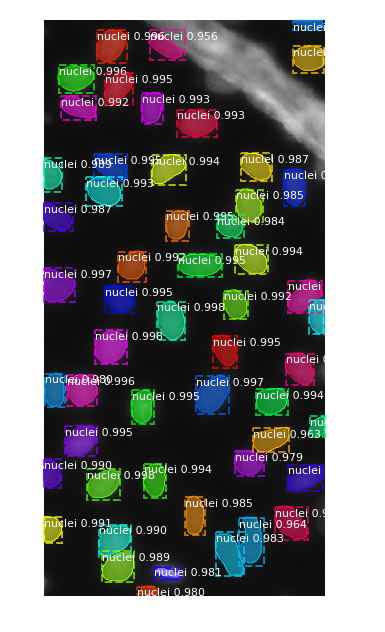

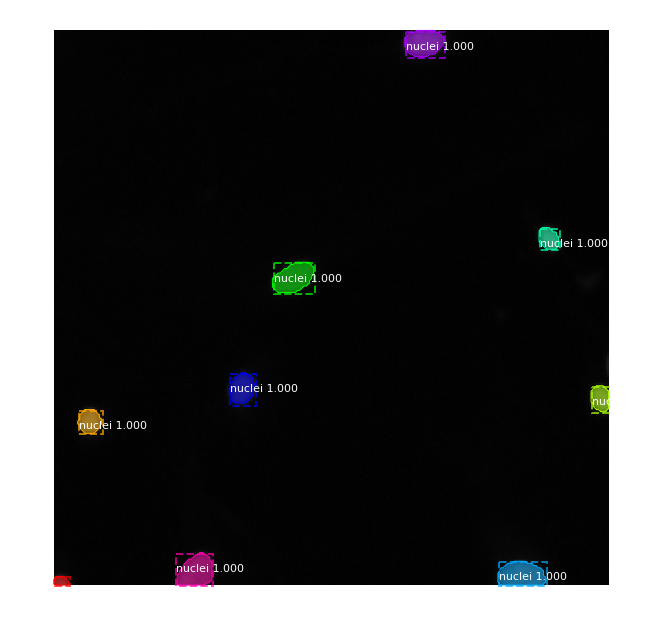

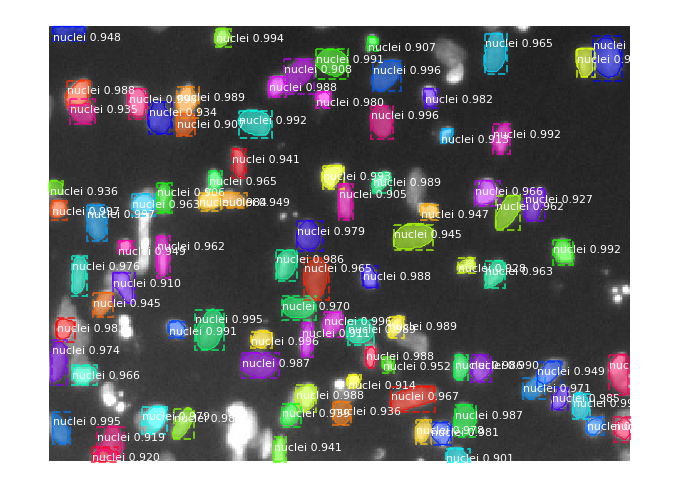

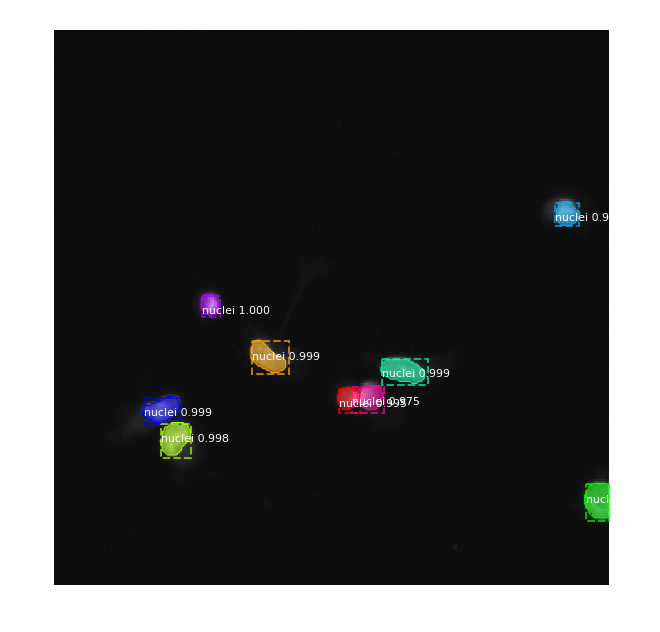

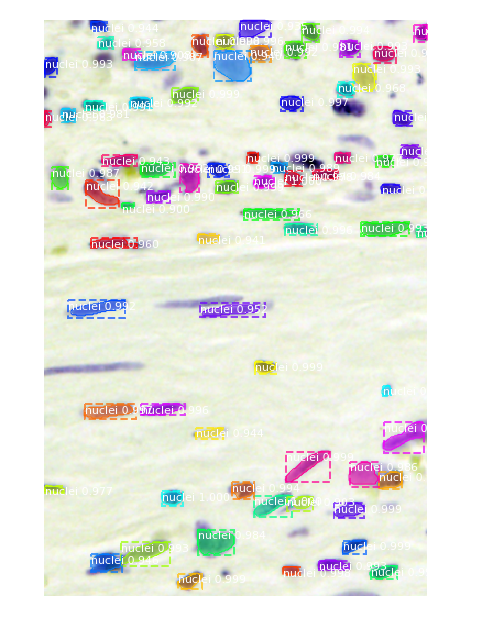

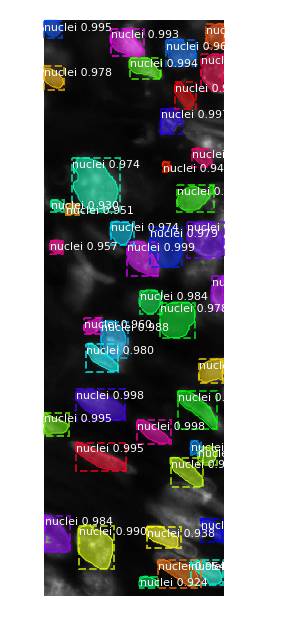

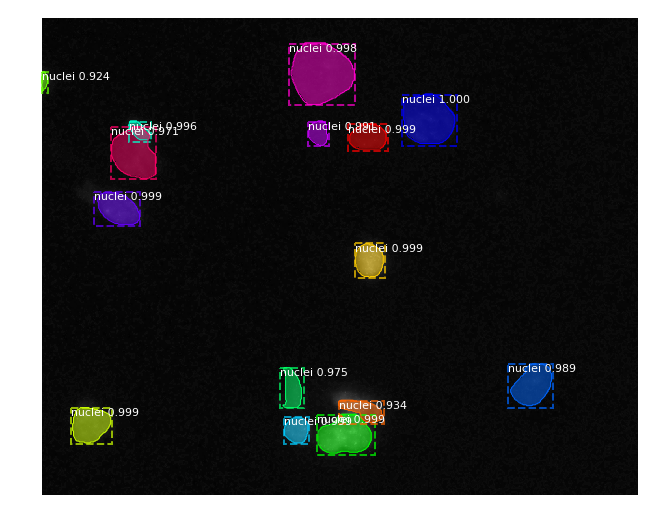

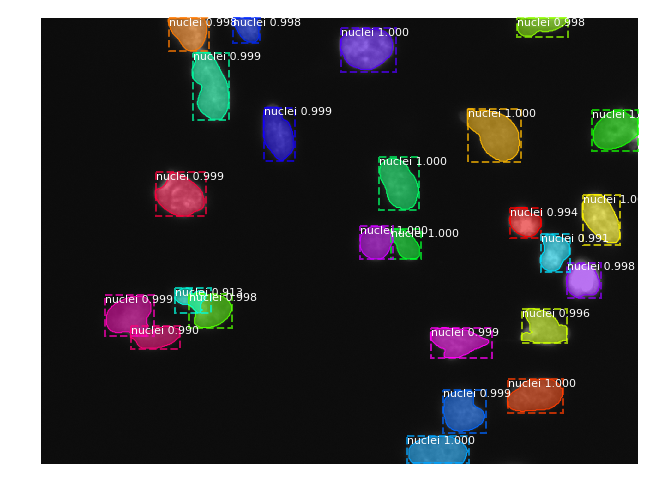

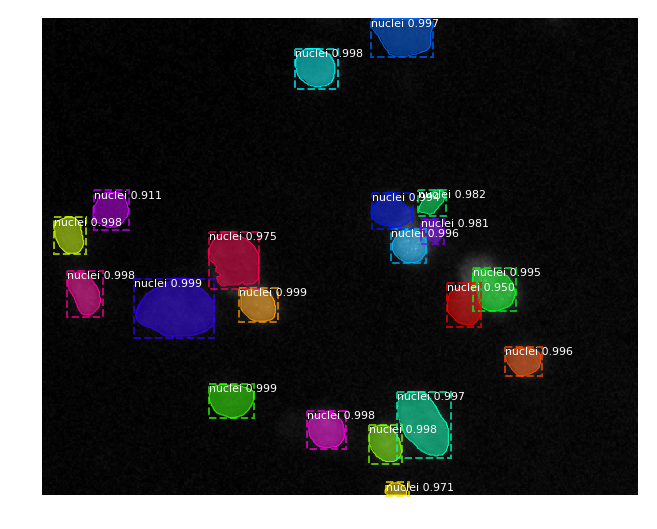

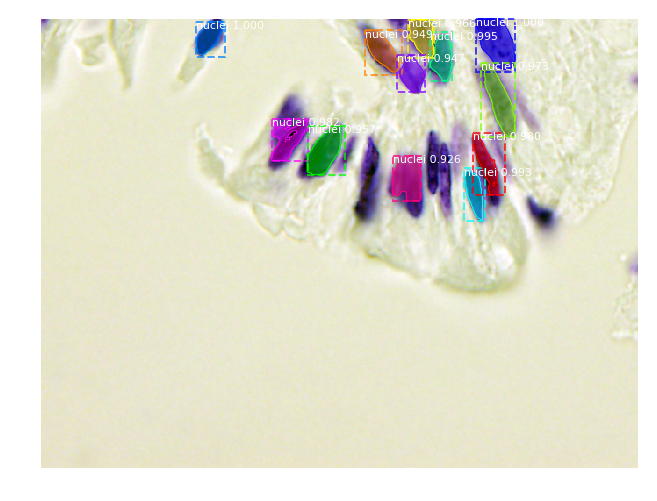

In [30]:
for id_ in ImageId_test[0:10]:
    image = skimage.io.imread(os.path.join(path_to_test,id_,"images",id_+".png"))[:,:,:3]
    results = model.detect([image], verbose=0)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(11, 11))

In [31]:
new_test_ids = []
rles = []
for n, id_ in enumerate(ImageId_test):
    image = skimage.io.imread(os.path.join(path_to_test,id_,"images",id_+".png"))[:,:,:3]
    
    print(n)
    # Run detection
    results = model.detect([image], verbose=0)

    # Visualize results
    r = results[0]
    
    rle = get_rle(r["masks"])
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [32]:
# Create submission DataFrame
path_to_sub='/home/ubuntu/Kaggle-Data-Science-Bowl/submission'
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join(path_to_sub,'2018-03-28_yohann_maskrcnn_new_data_epch60.csv'), index=False)
sub.head(10)

,ImageId,EncodedPixels
0,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,53720 13 54237 17 54755 20 55272 24 55790 26 5...
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,24685 11 25202 15 25719 18 26237 20 26755 22 2...
2,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,21178 8 21695 12 22212 15 22730 17 23249 18 23...
3,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,71442 6 71958 13 72475 16 72993 19 73510 22 74...
4,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,745 25 1263 28 1782 29 2301 29 2820 29 3340 28...
5,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,6797 5 7314 10 7832 12 8350 14 8868 16 9387 17...
6,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,11748 9 12264 14 12782 16 13300 18 13817 22 14...
7,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,24936 7 25452 12 25969 16 26486 19 27003 22 27...
8,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,41344 11 41861 16 42379 20 42897 22 43415 24 4...
9,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,28610 5 29123 14 29640 18 30157 21 30675 22 31...
